<a href="https://colab.research.google.com/github/ubsuny/PHY386/blob/Homework2025/2025/Final/drewalessi/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: I have used a randomly selected FITS file from earlier in the semester to develop this code (one that I had not previously worked on). I was initially unable to upload the FITS file to GitHub due to size constraints. I spent a couple of hours searching for a solution to this problem, including downloading Git Bash and cloning the repository locally so I could manually add and push the file, but was ultimately unsuccessful. In theory, any image could be substituted and run this code. However, once I had access to the correct FITS file this morning, I tried to do this and ran into issues with the data inside the file (specifically, declination data was way outside the acceptable range). Given more time, I may have been able to solve this, but since the file was uploaded pretty late in the game, I chose to stick with the image that works.

**Task 1: Data Exploration and Visualization**

In this section, the FITS file is uploaded, inspected, and displayed. The brightest 100 stars in the image are chosen for analysis and a catalog of their data is created. Additionally, pixel values of the stars are measured and plotted to give a distribution of star brightness across the sample.

In [1]:
# Install libraries
!pip install astropy astroquery scikit-learn matplotlib numpy photutils auto-stretch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 29.8 MB/s eta 0:00:00


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from auto_stretch import apply_stretch
from sklearn.cluster import KMeans
import requests
from io import BytesIO

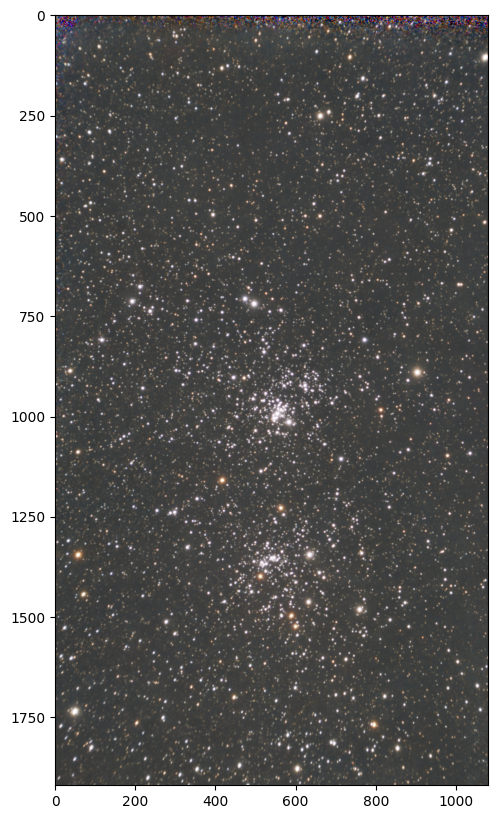

In [3]:
# Load FITS image and inspect contents

# Raw URL of FITS file on github
fits_url = "https://github.com/ubsuny/PHY386/raw/refs/heads/main/data/8.fits"

# fetch from github repository
response = requests.get(fits_url)
response.raise_for_status()
fits_data = fits.open(BytesIO(response.content))

# Load into HDUList using BytesIO (assume first extension holds rgb image)
hdul = fits.open(BytesIO(response.content))
image_data = np.transpose(hdul[0].data, (1,2,0))
hdul.close()

# Display the image (cropped as necessary)
fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data[:,:,:]))
plt.show()

In [4]:
# Find stars in the image and create a pandas table with the brightest 100
import pandas as pd
from astropy.wcs import WCS
from astropy.stats import mad_std

bkg_sigma = mad_std(np.mean(image_data, axis=2))

daofind = DAOStarFinder(fwhm=3.0, threshold=10 * bkg_sigma, min_separation = 15)
sources = daofind(np.mean(image_data, axis=2))

catalog = sources.to_pandas().sort_values('flux', ascending=False).head(100)

catalog

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
116,117,1070.775332,104.107462,0.365456,-0.658069,0.529658,25,56246.000000,848516.333333,-14.821651,-7.362143
2129,2130,47.978973,1736.783504,0.434488,-0.730781,0.492191,25,53295.333333,773417.333333,-14.721035,-7.300264
1097,1098,901.371614,890.425684,0.377630,-0.075196,0.060469,25,53486.333333,755433.666667,-14.695491,-7.367068
1659,1660,632.977291,1345.468367,0.391671,0.010205,0.085960,25,54460.333333,676763.666667,-14.576093,-7.548086
884,885,494.918374,719.244076,0.385278,0.093020,0.056171,25,55252.333333,660375.666667,-14.549478,-7.635705
...,...,...,...,...,...,...,...,...,...,...,...
1193,1194,647.985938,965.521986,0.579327,0.346099,0.178032,25,11924.333333,90693.333333,-12.393938,-6.087496
1460,1461,701.673293,1193.217441,0.527417,-0.086024,0.025603,25,12048.000000,90534.666667,-12.392037,-6.181261
1085,1086,300.775372,885.857961,0.580560,0.085138,0.022430,25,12615.333333,88584.333333,-12.368392,-6.191237
2146,2147,268.084783,1751.875880,0.543975,-0.500373,0.375233,25,9483.666667,88369.000000,-12.365750,-5.756134


In [5]:
# Add WCS coordinates to catalog
wcs = WCS(hdul[0].header, naxis=2)
print(wcs)
sky_coords = wcs.all_pix2world(catalog['xcentroid'], catalog['ycentroid'],1)
catalog['ra'] = sky_coords[0]
catalog['dec'] = sky_coords[1]
catalog

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 34.7003487181288 57.1194753878752 
CRPIX : 540.0 960.0 
PC1_1 PC1_2  : 0.0520595864810874 -0.998806529184181 
PC2_1 PC2_2  : 0.998484041182769 0.0520100010539242 
CDELT : -0.00110957761916186 0.00110975535350136 
NAXIS : 1080  1920  3


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec
116,117,1070.775332,104.107462,0.365456,-0.658069,0.529658,25,56246.000000,848516.333333,-14.821651,-7.362143,32.870655,57.644988
2129,2130,47.978973,1736.783504,0.434488,-0.730781,0.492191,25,53295.333333,773417.333333,-14.721035,-7.300264,36.316163,56.608658
1097,1098,901.371614,890.425684,0.377630,-0.075196,0.060469,25,53486.333333,755433.666667,-14.695491,-7.367068,34.517917,57.515748
1659,1660,632.977291,1345.468367,0.391671,0.010205,0.085960,25,54460.333333,676763.666667,-14.576093,-7.548086,35.479940,57.242336
884,885,494.918374,719.244076,0.385278,0.093020,0.056171,25,55252.333333,660375.666667,-14.549478,-7.635705,34.214516,57.054686
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1194,647.985938,965.521986,0.579327,0.346099,0.178032,25,11924.333333,90693.333333,-12.393938,-6.087496,34.700131,57.239450
1460,1461,701.673293,1193.217441,0.527417,-0.086024,0.025603,25,12048.000000,90534.666667,-12.392037,-6.181261,35.161625,57.311237
1085,1086,300.775372,885.857961,0.580560,0.085138,0.022430,25,12615.333333,88584.333333,-12.368392,-6.191237,34.575358,56.850057
2146,2147,268.084783,1751.875880,0.543975,-0.500373,0.375233,25,9483.666667,88369.000000,-12.365750,-5.756134,36.334096,56.853217


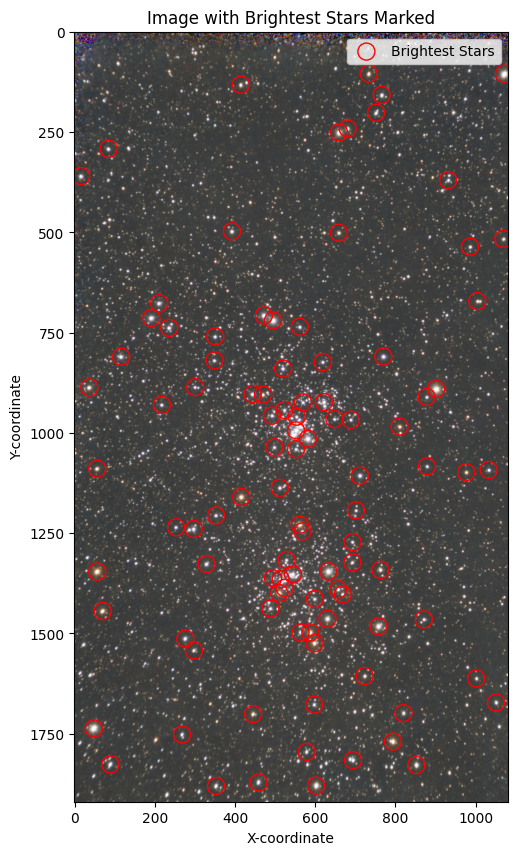

In [6]:
# Identify and label several stars for analysis

# Circle brightest 100 stars on image
fig = plt.figure(figsize=(10, 10))
plt.imshow(apply_stretch(image_data))

#Add scatter plot
plt.scatter(catalog['xcentroid'], catalog['ycentroid'], color='red', marker='o', facecolor='none', s=150, label='Brightest Stars')

#Add labels and legend
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Image with Brightest Stars Marked')
plt.legend()

#Show the plot
plt.show()

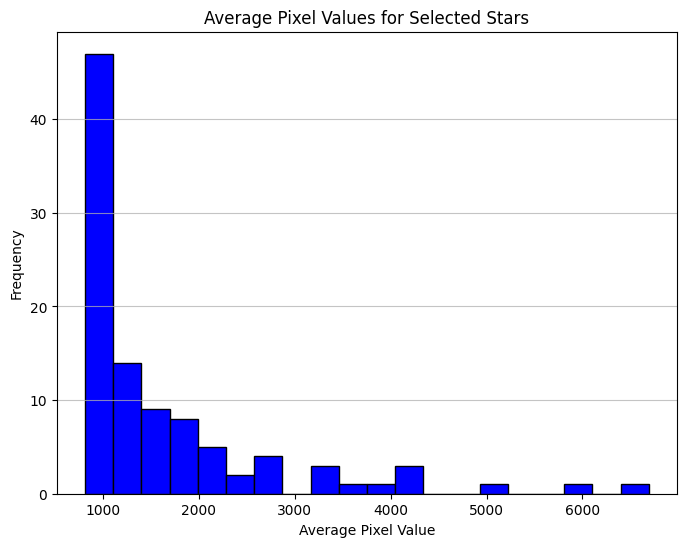

In [7]:
# Generate histograms of pixel values to assess brightness distribution.

#Function to extract average pixel values around a star
def get_average_pixel_values(image_data, x, y, window_size=15):
  """
  Extracts a square window around a star and calculates the average pixel value.

  Args:
    image_data: The image data as a NumPy array (Height, Width, Channels).
    x: The x-coordinate of the star.
    y: The y-coordinate of the star.
    window_size: The size of the square window (must be odd).

  Returns:
    The average pixel value within the window.
  """
  half_window = window_size // 2
  # Ensure the window is within image boundaries
  x_start = max(0, int(x) - half_window)
  x_end = min(image_data.shape[1], int(x) + half_window + 1)
  y_start = max(0, int(y) - half_window)
  y_end = min(image_data.shape[0], int(y) + half_window + 1)

  window = image_data[y_start:y_end, x_start:x_end, :]
  return np.mean(window)

# Extract average pixel values for each star in the catalog
average_pixel_values = []
for index, row in catalog.iterrows():
    avg_value = get_average_pixel_values(image_data, row['xcentroid'], row['ycentroid'])
    average_pixel_values.append(avg_value)

# Generate and display the histogram
plt.figure(figsize=(8, 6))
plt.hist(average_pixel_values, bins=20, color='blue', edgecolor='black')
plt.xlabel('Average Pixel Value')
plt.ylabel('Frequency')
plt.title('Average Pixel Values for Selected Stars')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Task 2: Physical Context and Research**

Color indices are calculated by taking the difference in magnitude between two different filters when measuring a star. The most common index used is B-V which takes the difference between a blue filter and a visual filter. Since the magnitude of a star is measured on a logarithmic scale, with brighter objects having lower magnitudes, a smaller B-V value denotes a hotter star with more blue light, while a cooler star will have a higher B-V value and more red light.

Color indexing correlates with the surface temperatures of stars, where hotter stars emit more blue light and cooler stars emit more red light. This results in the aforementioned distribution of B-V values depending on the temperature. Furthermore, this relationship allows astronomers to accurately estimate temperature based on a star’s color index.

Spectral classes are defined based on temperature as well as spectral features, and are classified into A, B, F, G, K, M, and O classes depending on these features. Therefore, the color of a star also allows for categorizing into the appropriate spectral class.

Main sequence stars follow a predictable trend when plotted on color-magnitude diagrams, which plot the apparent magnitude of stars against their color index. Hot, blue stars are at one end of the spectrum while cool, red stars are at the other. Giants and supergiants, on the other hand, tend to be redder than main sequence stars at a given luminosity, which sets them apart.

Star clusters tend to have a shared history and characteristics. Color indices are therefore important for astronomers analyzing star clusters to gain insights into their temperature, age, evolution, and other characteristics.


**Task 3: Data Processing and Feature Extraction**

In this section, photometric data is extracted for the selected stars in R, G, and B filters. Color indices are approximated using this data and this color information is used to predict the spectral class of the stars. These predicted spectral classes are then compared to the simplified spectral classes of the stars found in Simbad data. Finally, a Color-Magnitude Distribution (CMD) is plotted for the selected stars.

In [8]:
# Extract photometric data for selected stars in multiple filters (e.g., R, G, B)

from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

# Create apertures
apertures = CircularAperture(positions=catalog[['xcentroid', 'ycentroid']].values, r=5.0)

# Perform aperture photometry on each channel
phot_results = {}
for channel in range(image_data.shape[2]):
    phot_table = aperture_photometry(image_data[:, :, channel], apertures)
    phot_results[f'aperture_sum_channel_{channel}'] = phot_table['aperture_sum']

# Combine results into the catalog
for key, value in phot_results.items():
    catalog[key] = value

catalog

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,aperture_sum_channel_0,aperture_sum_channel_1,aperture_sum_channel_2
116,117,1070.775332,104.107462,0.365456,-0.658069,0.529658,25,56246.000000,848516.333333,-14.821651,-7.362143,32.870655,57.644988,1.126534e+06,1.134842e+06,1.248611e+06
2129,2130,47.978973,1736.783504,0.434488,-0.730781,0.492191,25,53295.333333,773417.333333,-14.721035,-7.300264,36.316163,56.608658,1.250674e+06,1.284645e+06,1.436738e+06
1097,1098,901.371614,890.425684,0.377630,-0.075196,0.060469,25,53486.333333,755433.666667,-14.695491,-7.367068,34.517917,57.515748,1.188724e+06,9.342089e+05,8.398572e+05
1659,1660,632.977291,1345.468367,0.391671,0.010205,0.085960,25,54460.333333,676763.666667,-14.576093,-7.548086,35.479940,57.242336,9.041531e+05,7.797596e+05,8.391200e+05
884,885,494.918374,719.244076,0.385278,0.093020,0.056171,25,55252.333333,660375.666667,-14.549478,-7.635705,34.214516,57.054686,8.552987e+05,7.453435e+05,8.494424e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1194,647.985938,965.521986,0.579327,0.346099,0.178032,25,11924.333333,90693.333333,-12.393938,-6.087496,34.700131,57.239450,1.282525e+05,1.185939e+05,1.200393e+05
1460,1461,701.673293,1193.217441,0.527417,-0.086024,0.025603,25,12048.000000,90534.666667,-12.392037,-6.181261,35.161625,57.311237,1.177831e+05,1.161717e+05,1.272156e+05
1085,1086,300.775372,885.857961,0.580560,0.085138,0.022430,25,12615.333333,88584.333333,-12.368392,-6.191237,34.575358,56.850057,1.163584e+05,1.142494e+05,1.253152e+05
2146,2147,268.084783,1751.875880,0.543975,-0.500373,0.375233,25,9483.666667,88369.000000,-12.365750,-5.756134,36.334096,56.853217,1.225106e+05,1.226889e+05,1.339613e+05


In [9]:
#Calculate color indices (e.g., B-V) for each star.

# Convert aperture data to magnitudes
# Magnitude = -2.5 * log10(flux) + constant
# The constant depends on calibration, but for B-V, it cancels out if the constant is the same for both filters.
# Using relative magnitudes for B-V calculation.
catalog['mag_B'] = -2.5 * np.log10(catalog['aperture_sum_channel_2'])
catalog['mag_V'] = -2.5 * np.log10(catalog['aperture_sum_channel_1'])

# Calculate B-V color index
# Note: B-V should be calculated based on data from UBV filters rather than RGB filters. The V filter is described as "green-yellow" so using green filter as a substitute here.
catalog['B-V'] = catalog['mag_B'] - catalog['mag_V']

# Assign spectral class based on B-V color index
def assign_spectral_class(bv_color):
  """
    Assign a stellar spectral class based on the B-V color index.

    Parameters
    ----------
    bv_color : float
        The B-V color index of a star. This value typically ranges from negative for very hot (blue) stars to positive for cooler (red) stars.

    Returns
    -------
    str
        The spectral class corresponding to the input B-V color index:
        - 'O' for bv_color < -0.3
        - 'B' for -0.3 <= bv_color < 0.0
        - 'A' for 0.0 <= bv_color < 0.3
        - 'F' for 0.3 <= bv_color < 0.6
        - 'G' for 0.6 <= bv_color < 0.9
        - 'K' for 0.9 <= bv_color < 1.5
        - 'M' for bv_color >= 1.5
  """
  if bv_color < -0.3:
      return 'O'
  elif bv_color < 0.0:
      return 'B'
  elif bv_color < 0.3:
      return 'A'
  elif bv_color < 0.6:
      return 'F'
  elif bv_color < 0.9:
      return 'G'
  elif bv_color < 1.5:
      return 'K'
  else:
      return 'M'

# Add spectral class to catalog
catalog['predicted_spectral_class'] = catalog['B-V'].apply(assign_spectral_class)

catalog


,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag,ra,dec,aperture_sum_channel_0,aperture_sum_channel_1,aperture_sum_channel_2,mag_B,mag_V,B-V,predicted_spectral_class
116,117,1070.775332,104.107462,0.365456,-0.658069,0.529658,25,56246.000000,848516.333333,-14.821651,-7.362143,32.870655,57.644988,1.126534e+06,1.134842e+06,1.248611e+06,-15.241068,-15.137338,-0.103729,B
2129,2130,47.978973,1736.783504,0.434488,-0.730781,0.492191,25,53295.333333,773417.333333,-14.721035,-7.300264,36.316163,56.608658,1.250674e+06,1.284645e+06,1.436738e+06,-15.393444,-15.271958,-0.121486,B
1097,1098,901.371614,890.425684,0.377630,-0.075196,0.060469,25,53486.333333,755433.666667,-14.695491,-7.367068,34.517917,57.515748,1.188724e+06,9.342089e+05,8.398572e+05,-14.810514,-14.926110,0.115596,A
1659,1660,632.977291,1345.468367,0.391671,0.010205,0.085960,25,54460.333333,676763.666667,-14.576093,-7.548086,35.479940,57.242336,9.041531e+05,7.797596e+05,8.391200e+05,-14.809560,-14.729902,-0.079658,B
884,885,494.918374,719.244076,0.385278,0.093020,0.056171,25,55252.333333,660375.666667,-14.549478,-7.635705,34.214516,57.054686,8.552987e+05,7.453435e+05,8.494424e+05,-14.822835,-14.680891,-0.141944,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1194,647.985938,965.521986,0.579327,0.346099,0.178032,25,11924.333333,90693.333333,-12.393938,-6.087496,34.700131,57.239450,1.282525e+05,1.185939e+05,1.200393e+05,-12.698309,-12.685156,-0.013153,B
1460,1461,701.673293,1193.217441,0.527417,-0.086024,0.025603,25,12048.000000,90534.666667,-12.392037,-6.181261,35.161625,57.311237,1.177831e+05,1.161717e+05,1.272156e+05,-12.761351,-12.662751,-0.098600,B
1085,1086,300.775372,885.857961,0.580560,0.085138,0.022430,25,12615.333333,88584.333333,-12.368392,-6.191237,34.575358,56.850057,1.163584e+05,1.142494e+05,1.253152e+05,-12.745009,-12.644635,-0.100374,B
2146,2147,268.084783,1751.875880,0.543975,-0.500373,0.375233,25,9483.666667,88369.000000,-12.365750,-5.756134,36.334096,56.853217,1.225106e+05,1.226889e+05,1.339613e+05,-12.817448,-12.722013,-0.095435,B


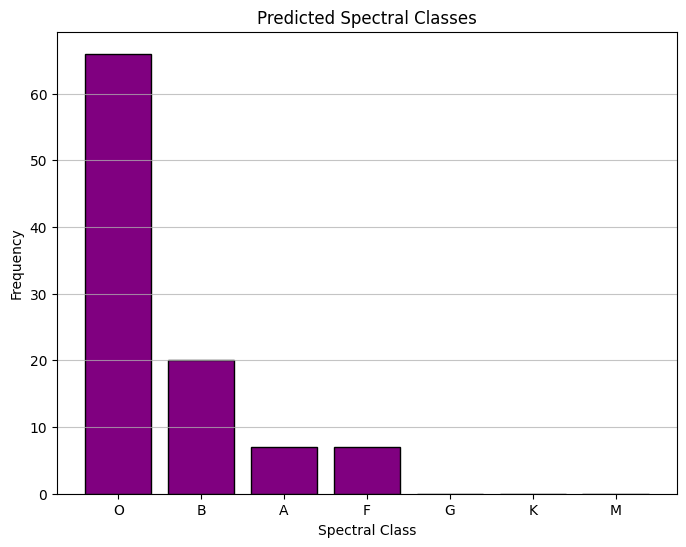

In [10]:
# Create histogram of predicted spectral classes

plt.figure(figsize=(8, 6))
plt.hist(catalog['predicted_spectral_class'], bins=np.arange(8) - 0.5, rwidth=0.8, color='purple', edgecolor='black')
plt.xlabel('Spectral Class')
plt.ylabel('Frequency')
plt.title('Predicted Spectral Classes')
plt.xticks(range(7), ['O', 'B', 'A', 'F', 'G', 'K', 'M'])
plt.grid(axis='y', alpha=0.75)
plt.show()

In [11]:
# Import Simbad
from astroquery.simbad import Simbad
import astropy.units as u
from astropy.coordinates import SkyCoord
from tqdm import tqdm

options = Simbad.list_votable_fields()

In [12]:
# Use the SIMBAD catalog to retrieve the spectral classifications of the same stars.

# Add Simbad data to catalog
Simbad.ROW_LIMIT = 1
Simbad.reset_votable_fields()
Simbad.add_votable_fields("mesdistance", "V", "sp", "otype", "ids")

for idx, row in tqdm(catalog.iterrows(), total=catalog.shape[0]):
  ra, dec = row["ra"], row["dec"]
  coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
  try:
    result = Simbad.query_region(coord, radius="50s") #adjust radius to find useful search area
    s = result[0]
    if result:
      catalog.at[idx, "star_name"] = s["main_id"]
      catalog.at[idx, "spectral_type"] = s["sp_type"]
      catalog.at[idx, "object_type"] = s["otype"]
      catalog.at[idx, "visual_mag"] = s["V"]
      dist = s["mesdistance.dist"]
      catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None
      catalog.at[idx, "simbad_distance_ly"] = float(dist) * 3.26156 if dist is not None else None

  except Exception as e:
      print(f"Error querying Simbad for {idx}: {e}")

  4%|▍         | 4/100 [00:00<00:16,  5.83it/s]/usr/local/lib/python3.11/dist-packages/pandas/core/internals/base.py:363: UserWarning: Warning: converting a masked element to nan.
  arr[indexer] = value
  5%|▌         | 5/100 [00:00<00:15,  6.25it/s]<ipython-input-12-dbecb878da75>:20: UserWarning: Warning: converting a masked element to nan.
  catalog.at[idx, "simbad_distance_pc"] = float(dist) if dist is not None else None
<ipython-input-12-dbecb878da75>:21: UserWarning: Warning: converting a masked element to nan.
  catalog.at[idx, "simbad_distance_ly"] = float(dist) * 3.26156 if dist is not None else None
100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


In [13]:
catalog['spectral_type'].unique() #just use first letter to simplify

array(['B5Ia', 'B2Ia', 'A5.7V', '', 'B8', 'F1', 'G3V', 'A0Ib', 'M3-M4Iab',
       'B1.5Ib', 'G0.3V', 'B2Ib-II:p', 'A', 'F4.5V', 'A0III_Kn', 'K1.9V',
       'G8III', 'O9.5I', 'K1V', 'K0.6V', 'A0.5V', 'G2.7V', 'B1Ib', 'G1V',
       'B8III', 'G5', 'F8.2V', 'A5:', 'K5', 'B1III', 'F3.7V', 'G5.4V',
       'B1.5III', 'K0III', 'G4.5V', 'K6.1V', 'A4III', 'A2Vm', 'G0',
       'B1.0III', 'B9V', 'A2.1V', 'K0.5V', 'B0.5V', 'A8.3V', 'K1.7V',
       'OB-', 'G5V'], dtype=object)

In [14]:
# Extract broad spectral class from detailed spectral type
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def extract_spectral_class(s):
  """ simplify spectral classes, e.g. M1 --> M

      Input: Spectral type (string)

      Returns: Spectral class (string)
  """
  if s is np.nan:
    return s
  if s is None:
    return None
  # Add a check for empty string
  if isinstance(s, str) and len(s) > 0:
      return s[0]
  else:
      # Return a placeholder or None for empty strings or other non-string types
      return None

catalog['simple_spectral_class'] = catalog['spectral_type'].apply(extract_spectral_class)
catalog.head(100)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,...,mag_V,B-V,predicted_spectral_class,star_name,spectral_type,object_type,visual_mag,simbad_distance_pc,simbad_distance_ly,simple_spectral_class
116,117,1070.775332,104.107462,0.365456,-0.658069,0.529658,25,56246.000000,848516.333333,-14.821651,...,-15.137338,-0.103729,B,* 5 Per,B5Ia,s*b,6.350000,1907.305,6220.789696,B
2129,2130,47.978973,1736.783504,0.434488,-0.730781,0.492191,25,53295.333333,773417.333333,-14.721035,...,-15.271958,-0.121486,B,* 10 Per,B2Ia,s*b,6.260000,2150.000,7012.354000,B
1097,1098,901.371614,890.425684,0.377630,-0.075196,0.060469,25,53486.333333,755433.666667,-14.695491,...,-14.926110,0.115596,A,2MASS J02175914+5730339,A5.7V,*,15.568000,2937.720,9581.550043,A
1659,1660,632.977291,1345.468367,0.391671,0.010205,0.085960,25,54460.333333,676763.666667,-14.576093,...,-14.729902,-0.079658,B,NGC 884 2173,,*,13.491000,1040.150,3392.511634,None
884,885,494.918374,719.244076,0.385278,0.093020,0.056171,25,55252.333333,660375.666667,-14.549478,...,-14.680891,-0.141944,B,NGC 869 9,,*,NaN,2558.199,8343.719530,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193,1194,647.985938,965.521986,0.579327,0.346099,0.178032,25,11924.333333,90693.333333,-12.393938,...,-12.685156,-0.013153,B,[CCR2014] 2024,,*,22.544701,NaN,NaN,None
1460,1461,701.673293,1193.217441,0.527417,-0.086024,0.025603,25,12048.000000,90534.666667,-12.392037,...,-12.662751,-0.098600,B,[CCR2014] 9481,,*,20.723400,NaN,NaN,None
1085,1086,300.775372,885.857961,0.580560,0.085138,0.022430,25,12615.333333,88584.333333,-12.368392,...,-12.644635,-0.100374,B,2MASS J02182066+5650501,K1.7V,*,18.884001,NaN,NaN,K
2146,2147,268.084783,1751.875880,0.543975,-0.500373,0.375233,25,9483.666667,88369.000000,-12.365750,...,-12.722013,-0.095435,B,BD+56 610,OB-,*,9.700000,2392.917,7804.642371,O


In [15]:
# Compare your calculated color indices with the spectral classifications from SIMBAD to assess consistency.

# For only stars with a value for simple_spectral_class, determine whether this value matches the star's value for predicted_spectral_class.
# Print the simple and predicted classes for each star.
# Calculate the percentage of stars that match.

# Filter for stars with simple_spectral_class values
matched_stars = catalog.dropna(subset=['simple_spectral_class'])

match_count = 0
# Iterate through the filtered stars and compare classes
for index, row in matched_stars.iterrows():
    simple_class = row['simple_spectral_class']
    predicted_class = row['predicted_spectral_class']
    print(f"Star: {row['star_name']}, Simple Class: {simple_class}, Predicted Class: {predicted_class}")
    if simple_class == predicted_class:
        match_count += 1

# Calculate the percentage of matches
total_compared = len(matched_stars)
if total_compared > 0:
    percentage_match = (match_count / total_compared) * 100
    print(f"\nPercentage of stars where simple_spectral_class matches predicted_spectral_class: {percentage_match:.2f}%")
else:
    print("\nNo stars with a simple_spectral_class to compare.")

Star: *   5 Per, Simple Class: B, Predicted Class: B
Star: *  10 Per, Simple Class: B, Predicted Class: B
Star: 2MASS J02175914+5730339, Simple Class: A, Predicted Class: A
Star: NGC   869  1121, Simple Class: B, Predicted Class: B
Star: [CKR2007] 3, Simple Class: F, Predicted Class: B
Star: HD  13403, Simple Class: G, Predicted Class: B
Star: HD  14899, Simple Class: A, Predicted Class: B
Star: V* SU Per, Simple Class: M, Predicted Class: F
Star: HD  13841, Simple Class: B, Predicted Class: B
Star: 2MASS J02225190+5715235, Simple Class: G, Predicted Class: A
Star: HD  13866, Simple Class: B, Predicted Class: B
Star: AG+57  312, Simple Class: A, Predicted Class: G
Star: 2MASS J02231429+5711200, Simple Class: F, Predicted Class: G
Star: HD  14864, Simple Class: A, Predicted Class: B
Star: 2MASS J02172221+5721338, Simple Class: K, Predicted Class: B
Star: HD  14543, Simple Class: G, Predicted Class: F
Star: HD  13831, Simple Class: O, Predicted Class: B
Star: HD  14039, Simple Class: K, 

There is only about a 30% match rate between the what the calculations predicted for the spectral class and what the SIMBAD data shows, so this is not a very accurate method. Several sources of error may contribute to this discrepancy. First, spectral class is not determined based solely on color, so the SIMBAD data may be incorporating additional information related to spectroscopy or other factors that determine class. Secondly, the B-V metric is best determined using UBV data rather than using RGB data as a proxy. Finally, the data was not calibrated to a known source which can skew the results.

<ipython-input-16-7a3a0184a74c>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


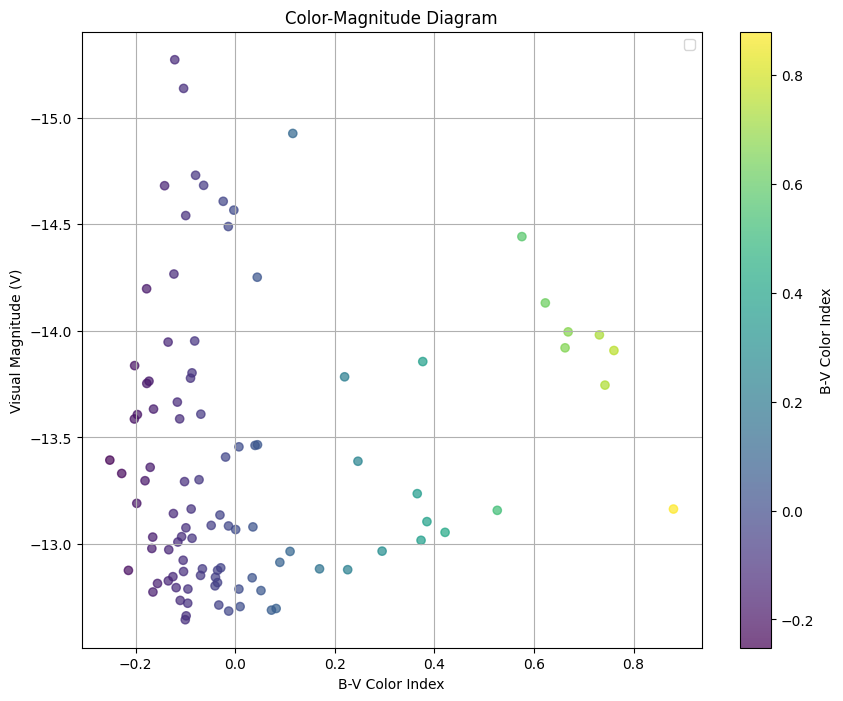

In [16]:
# Plot color-magnitude diagrams to visualize the distribution of stars

# Plot color-magnitude diagram
plt.figure(figsize=(10, 8))
plt.scatter(catalog['B-V'], catalog['mag_V'], c=catalog['B-V'], cmap='viridis', alpha=0.7)
plt.gca().invert_yaxis()  # Invert magnitude axis
plt.xlabel('B-V Color Index')
plt.ylabel('Visual Magnitude (V)')
plt.title('Color-Magnitude Diagram')
plt.colorbar(label='B-V Color Index')

plt.legend()
plt.grid(True)
plt.show()

**Task 4: Modeling and Analysis**

In this section, the data found above is compared to main sequence data from a known sample. The distance to the stars is estimated based on this comparison.

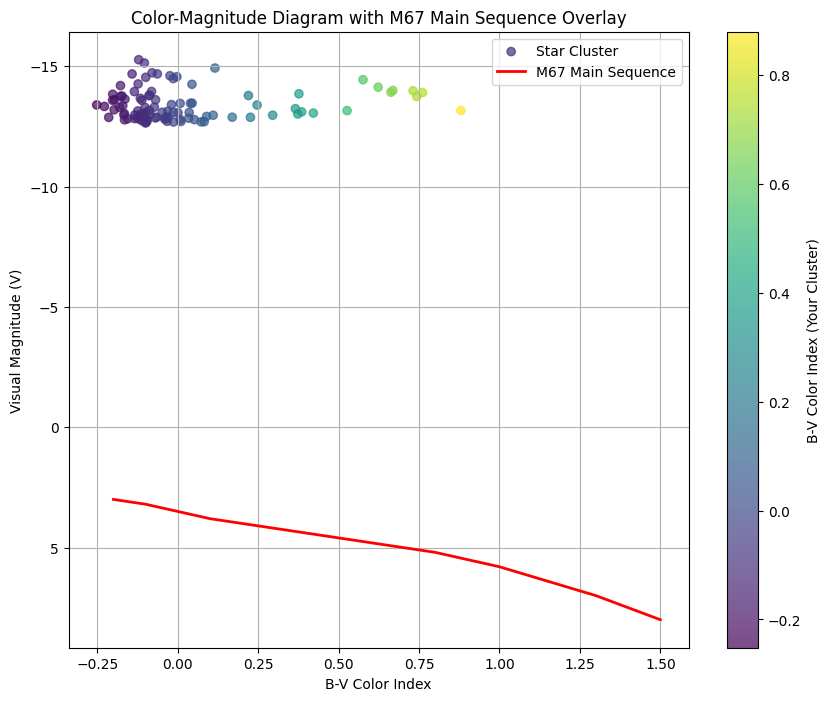

In [17]:
# Overlay main sequence data from a known star cluster (e.g., Messier 67)

# Approximated from published CMDs of M67.
m67_bv = np.array([-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
m67_abs_mag = np.array([3.0, 3.2, 3.5, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.5, 5.8, 6.2, 6.6, 7.0, 7.5, 8.0])

# Plot color-magnitude diagram for star cluster
plt.figure(figsize=(10, 8))
plt.scatter(catalog['B-V'], catalog['mag_V'], c=catalog['B-V'], cmap='viridis', alpha=0.7, label='Star Cluster')

# Overlay the M67 main sequence data
plt.plot(m67_bv, m67_abs_mag, color='red', linestyle='-', linewidth=2, label='M67 Main Sequence')


plt.gca().invert_yaxis()  # Invert magnitude axis
plt.xlabel('B-V Color Index')
plt.ylabel('Visual Magnitude (V)')
plt.title('Color-Magnitude Diagram with M67 Main Sequence Overlay')
plt.colorbar(label='B-V Color Index (Your Cluster)')

plt.legend()
plt.grid(True)
plt.show()

To determine distance, the standard procedure is to find the distance modulus by comparing the y-axis separation of the two sequences. The distance modulus is then input to a standard formula to estimate the distance.

In [18]:
# Calculate the distance modulus between the star cluster and the main sequence data

"""
  The distance modulus (m - M) is the difference between apparent magnitude (m) and absolute magnitude (M).
  By aligning the main sequence of the star cluster data with the main sequence of a known cluster (like M67),
  the vertical shift required to align them gives an estimate of the distance modulus.
  We will find the median difference in apparent magnitude for stars in the catalog that fall within the B-V
  range of the M67 main sequence data.
"""

# Create an interpolation function for the M67 main sequence
m67_main_sequence_interp = np.interp(catalog['B-V'], m67_bv, m67_abs_mag)

# Calculate the difference in apparent magnitude between star cluster and interpolated M67 main sequence
# Only consider stars where the B-V is within the range of the M67 data to avoid extrapolation
valid_bv_mask = (catalog['B-V'] >= m67_bv.min()) & (catalog['B-V'] <= m67_bv.max())

# Calculate the difference in magnitude for the masked stars
magnitude_difference = catalog['mag_V'][valid_bv_mask] - m67_main_sequence_interp[valid_bv_mask]

# The median of these differences is an estimate of the distance modulus.
estimated_distance_modulus = np.median(magnitude_difference)

print(f"\nEstimated Distance Modulus: {estimated_distance_modulus:.2f}")

# Estimate the distance using the distance modulus formula:
# m - M = 5 * log10(d/10pc)
# Rearranging to solve for distance (d):
# d = 10 pc * 10^((m - M) / 5)

estimated_distance_pc = 10 * (10**(estimated_distance_modulus / 5))

print(f"Estimated Distance: {estimated_distance_pc:.4f} parsecs")
print(f"Estimated Distance: {estimated_distance_pc * 3.26156:.4f} light-years")



Estimated Distance Modulus: -16.69
Estimated Distance: 0.0046 parsecs
Estimated Distance: 0.0150 light-years


Analysis:
This method could be applied in granular detail to estimate distance for each individual star, but given how far off the results are from the Simbad distance data, I wouldn't expect any useful data from this. In general, the calculations throughout have been approximations that have likely compounded errors along the way. I also expect that analyzing the brightest stars in the image may bias the selection toward the hotter, bluer stars and away from fainter, redder stars which doesn't give a representative view of the population. Ideally, the star data would show a closer correlation with the main sequence data, which could give insight into where the stars are in their life cycle based on their position in the main sequence.